In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import tqdm

import torch
import torch_geometric.data

from utils import plot_gel_conds, compare_gel_conds

from sklearn.metrics.pairwise import cosine_similarity
from similarity import calculate_tanimoto_similarity, get_zeolite_similarity, maximum_mean_discrepancy, visualize_smiles

In [11]:
with open(f'ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)

In [12]:
# Get all datapoints from dataset object
all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=False, return_dataframe=True)
# all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=True, return_dataframe=True)

# Create DataFrame with all datapoints
df = all_datapoints[1]
df['zeo'] = all_datapoints[3]
df['osda'] = all_datapoints[13]
df

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
0,400.0,0.000000,99.0,250.0,0.0,0.05,0.250000,0.0,31.000006,0.200000,150.000000,504.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
1,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,7.500000,0.500000,175.000000,168.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
2,400.0,0.000000,99.0,250.0,0.0,0.12,0.270000,0.0,44.000000,0.150000,150.000000,144.000000,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
3,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,20.000000,0.000000,115.720856,660.165100,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
4,2.5,1.717997,99.0,250.0,0.0,0.00,2.285717,0.0,28.571430,1.142857,125.000000,72.000000,BPH,CC[N+](CC)(CC)CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,30.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,135.000000,558.916321,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23957,40.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,160.000000,240.032150,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23958,70.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,53.891212,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23959,100.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,193.911392,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3


In [13]:
# # Standard scaling (only if MMD between synthesis is used)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# zeos, osdas = df['zeo'], df['osda']
# df = pd.DataFrame(scaler.fit_transform(df.drop(columns=['zeo', 'osda'])), columns=dataset.ratio_names+dataset.cond_names)
# df['zeo'] = zeos
# df['osda'] = osdas
# # df

# 1) OSDA similarity

In [14]:
osda_sims, syn_sims = [], []
zeos, osda_refs, osda_srcs = [], [], []
for zeo, c in df['zeo'].value_counts().items():

    if zeo != 'Dense/Amorphous':
        df_zeo = df[df['zeo']==zeo]
        df_zeo = df_zeo.drop(columns=['zeo'])
        unique_osdas = list(df_zeo['osda'].value_counts().keys()) # unique OSDAs for this zeolite
        # print(zeo)
        # print('n_syn:', c)
        # print('n_osda:', len(unique_osdas))
        
        # osda_sims, syn_sims = [], [] # if you one to plot for each zeolite, but need to comment the top 2 lines

        for ref_idx in range(len(unique_osdas)):
            osda_ref = unique_osdas[ref_idx] # Reference OSDA
            df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

            for src_idx in range(ref_idx): # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
                osda_src = unique_osdas[src_idx] # Source OSDA
                df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])

                # 1) OSDA SIMILARITY
                if (osda_ref == 'OSDA-free') or (osda_src == 'OSDA-free'):
                    osda_sim = 0.
                else:
                    osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

                # 2) SYNTHESIS SIMILARITY
                # 2A) Mean cosine similarity of all pairs of synthesis conditions
                syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                # 2B) Cosine similarity of mean synthesis conditions
                # syn_sim = cosine_similarity(df_zeo_osda_src.mean().values.reshape(1, -1), df_zeo_osda_ref.mean().values.reshape(1, -1))[0][0]

                # # 2C) Maximum Mean Discrepancy
                # syn_sim = maximum_mean_discrepancy(df_zeo_osda_src.values, df_zeo_osda_ref.values)

                osda_sims.append(osda_sim), syn_sims.append(syn_sim)
                zeos.append(zeo), osda_refs.append(osda_ref), osda_srcs.append(osda_src)
                
                # plot_gel_conds(df_zeo_osda_src, label='Current')
                # plot_gel_conds(df_zeo_osda_ref, label='Most \n freq. OSDA')
                # print()

        # # Plot OSDA vs synthesis similarity for specific zeolite - need to comment the top 2 lines and uncomment the osda_sims, syn_sims in inner loop
        # plt.figure(figsize=(5,5),dpi=100)
        # plt.scatter(osda_sims, syn_sims, alpha=0.1)
        # plt.xlabel('OSDA similarity')
        # plt.ylabel('Synthesis similarity')
        # plt.show()

In [15]:
df_osda_sim = pd.DataFrame({'zeo': zeos, 'osda_ref': osda_refs, 'osda_src': osda_srcs, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
df_osda_sim = df_osda_sim.sort_values('osda_sim', ascending=False) # sort by OSDA similarity
df_osda_sim

,zeo,osda_ref,osda_src,osda_sim,syn_sim
56396,SFS,CC[N+]1(CC)C(C)CCC2CCCCC21,CC[N+]1(CC)C(C)CC[C@H]2CCCCC21,1.0,0.715194
56397,SFS,CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21,CC[N+]1(CC)C(C)CC[C@H]2CCCCC21,1.0,0.950129
38911,LTA,C1COCCOCCOCCOCCN1,C1COCCOCCOCCOCCOCCN1,1.0,1.000000
44195,TON,NCCCCCCCCCCN,NCCCCCCCCCCCCN,1.0,0.993638
44112,TON,C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1,C[n+]1ccn(CCCCCCCCn2cc[n+](C)c2)c1,1.0,0.981474
...,...,...,...,...,...
17016,CHA,C1CNCCNCCCNCCNC1,CCC(C)N,0.0,0.435288
17015,CHA,C1CNCCNCCCNCCNC1,CCN1C=CN(C)C1C(=O)[O-],0.0,0.693650
17014,CHA,C1CNCCNCCCNCCNC1,NCCCN,0.0,0.743370
17013,CHA,C1CNCCNCCCNCCNC1,CN,0.0,0.367784


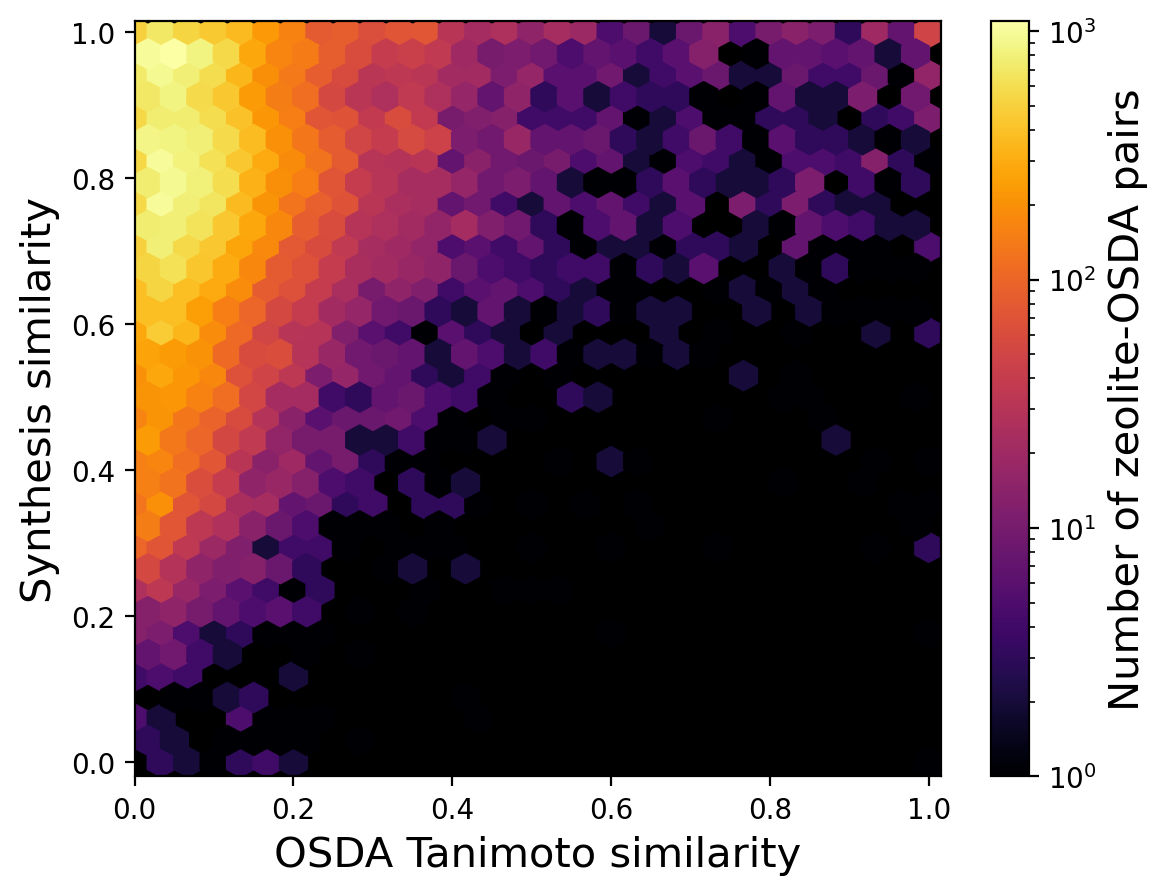

In [16]:
plt.figure(figsize=(6.5,5),dpi=200)
plt.hexbin(df_osda_sim['osda_sim'], df_osda_sim['syn_sim'], gridsize=30, mincnt=0, bins='log', cmap='inferno', facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.xlabel('OSDA Tanimoto similarity', fontsize=15)
plt.ylabel('Synthesis similarity', fontsize=15)
cb = plt.colorbar()
cb.set_label('Number of zeolite-OSDA pairs', fontsize=15)
plt.xlim(-0.00,1.015)
plt.ylim(-0.02,1.015)
# plt.xlim(-0.00,1.02) 
# plt.ylim(-0.01,2)
plt.show()

<Figure size 432x288 with 0 Axes>

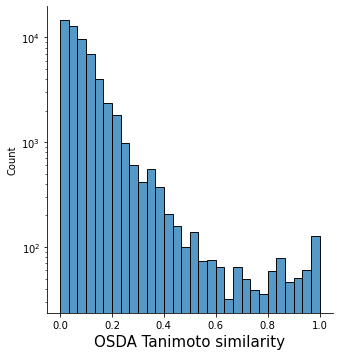

In [17]:
plt.figure()
sns.displot(df_osda_sim['osda_sim'], bins=30)
plt.xlabel('OSDA Tanimoto similarity', fontsize=15)
plt.yscale('log')

0
zeo: SFS
osda 1: CC[N+]1(CC)C(C)CC[C@H]2CCCCC21 7
osda 2: CC[N+]1(CC)C(C)CCC2CCCCC21 1
osda similarity: 1.0
synthesis similarity: 0.71519405


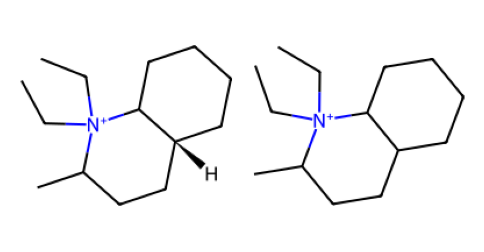

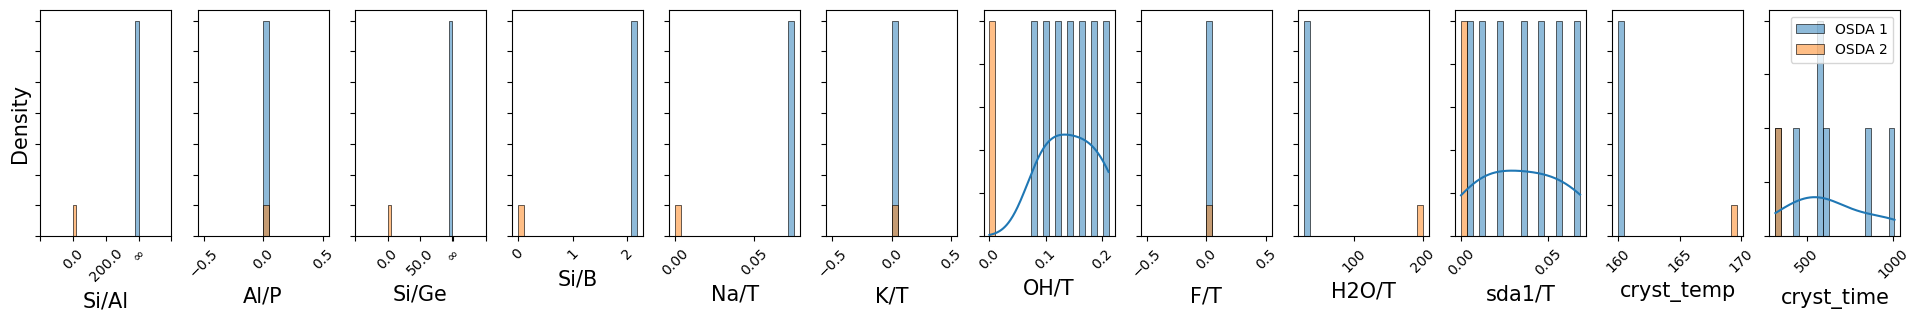

1
zeo: SFS
osda 1: CC[N+]1(CC)C(C)CC[C@H]2CCCCC21 7
osda 2: CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21 1
osda similarity: 1.0
synthesis similarity: 0.9501292


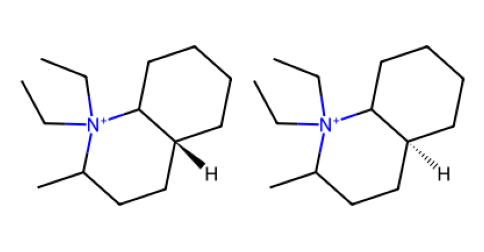

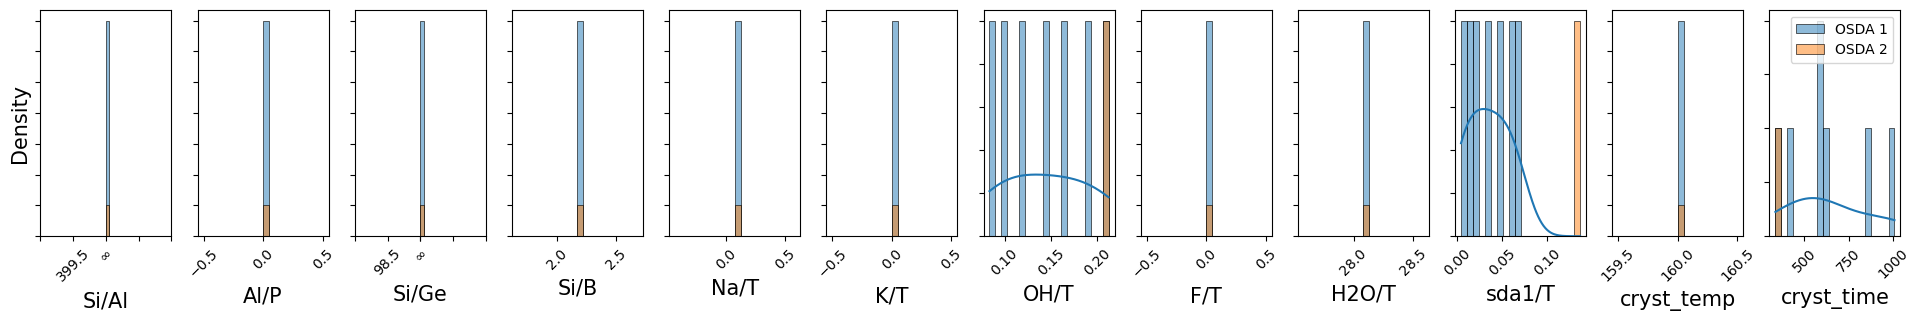

2
zeo: LTA
osda 1: C1COCCOCCOCCOCCOCCN1 1
osda 2: C1COCCOCCOCCOCCN1 1
osda similarity: 1.0
synthesis similarity: 1.0


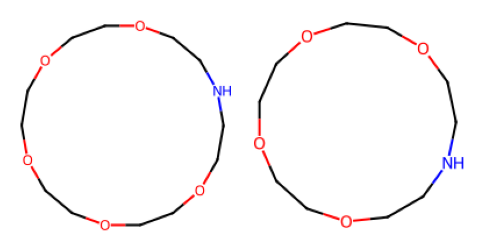

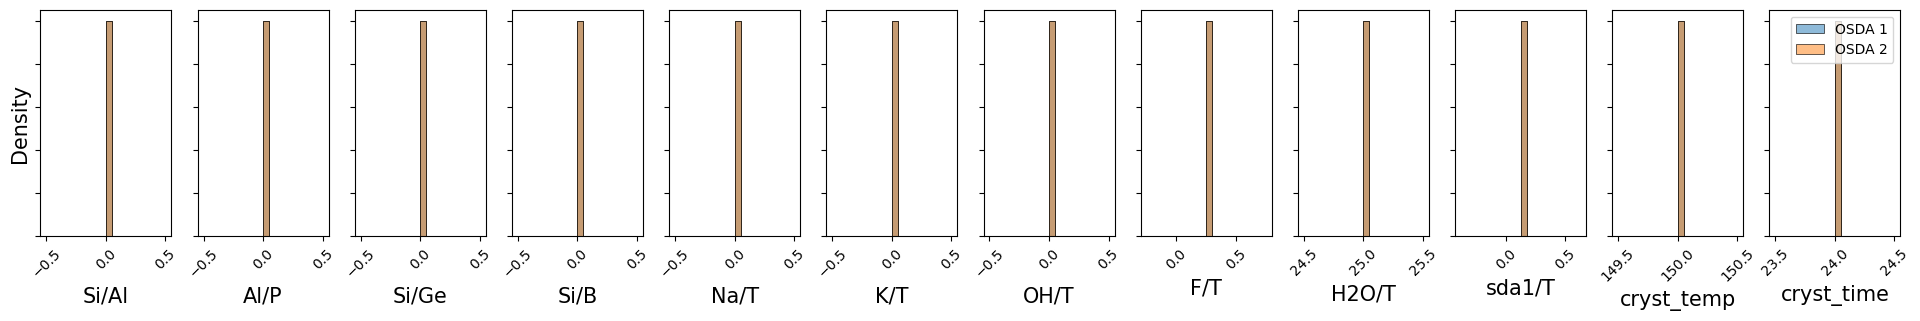

3
zeo: TON
osda 1: NCCCCCCCCCCCCN 7
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.9936379


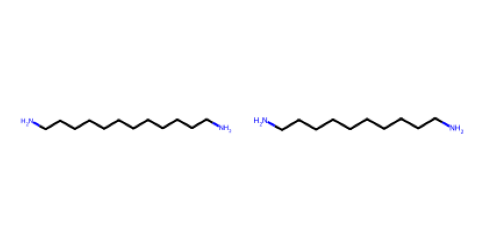

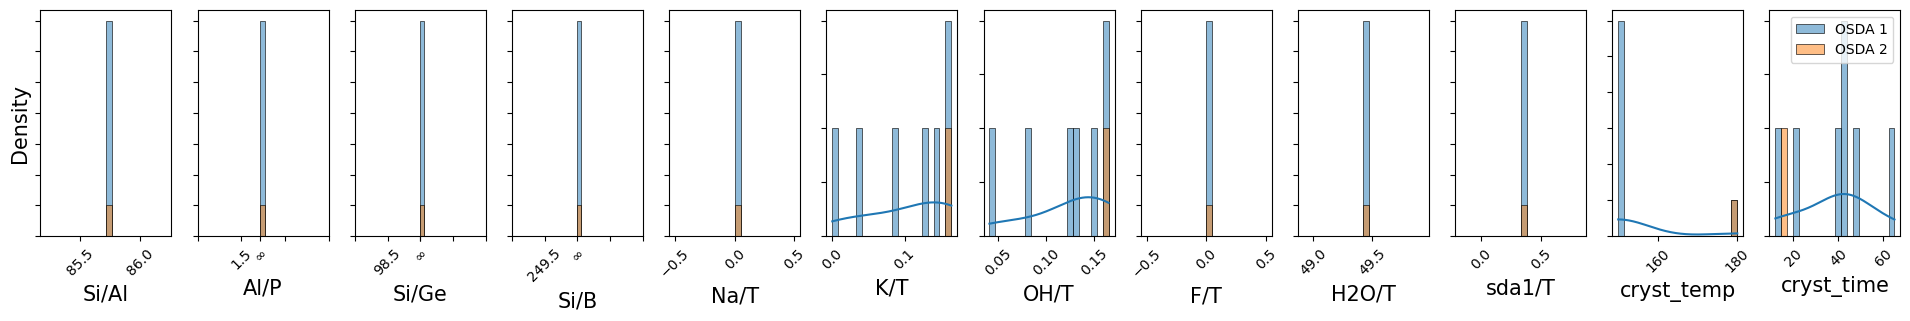

4
zeo: TON
osda 1: C[n+]1ccn(CCCCCCCCn2cc[n+](C)c2)c1 3
osda 2: C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1 1
osda similarity: 1.0
synthesis similarity: 0.9814744


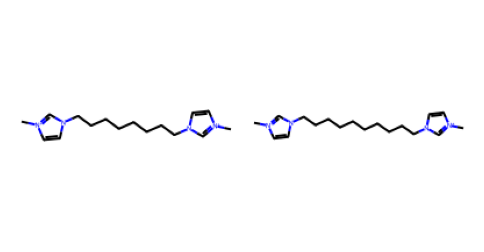

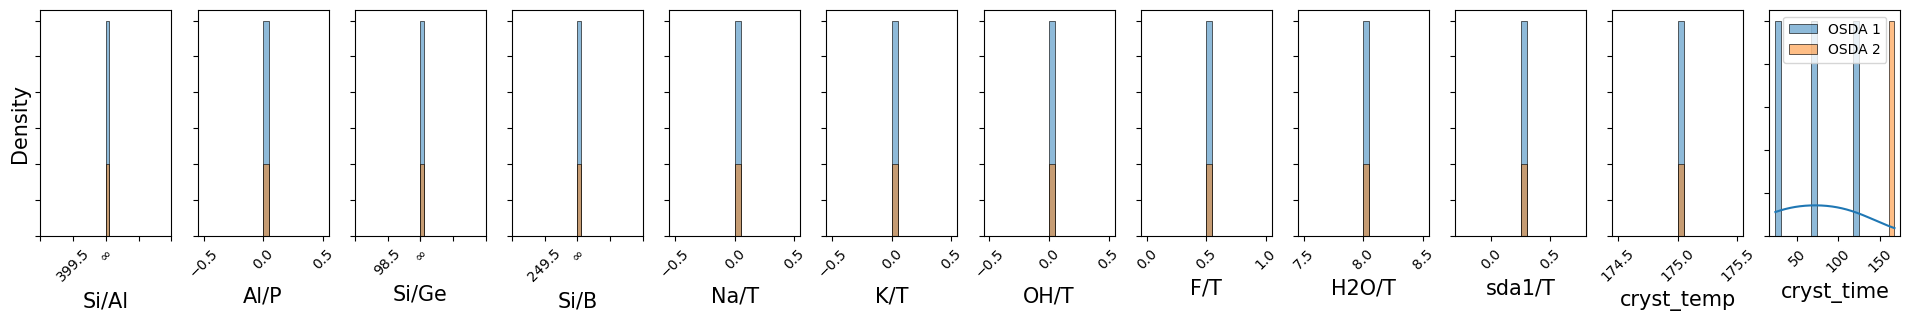

5
zeo: MRE
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 3
osda similarity: 1.0
synthesis similarity: 0.9225557


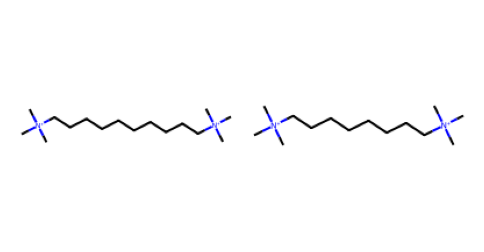

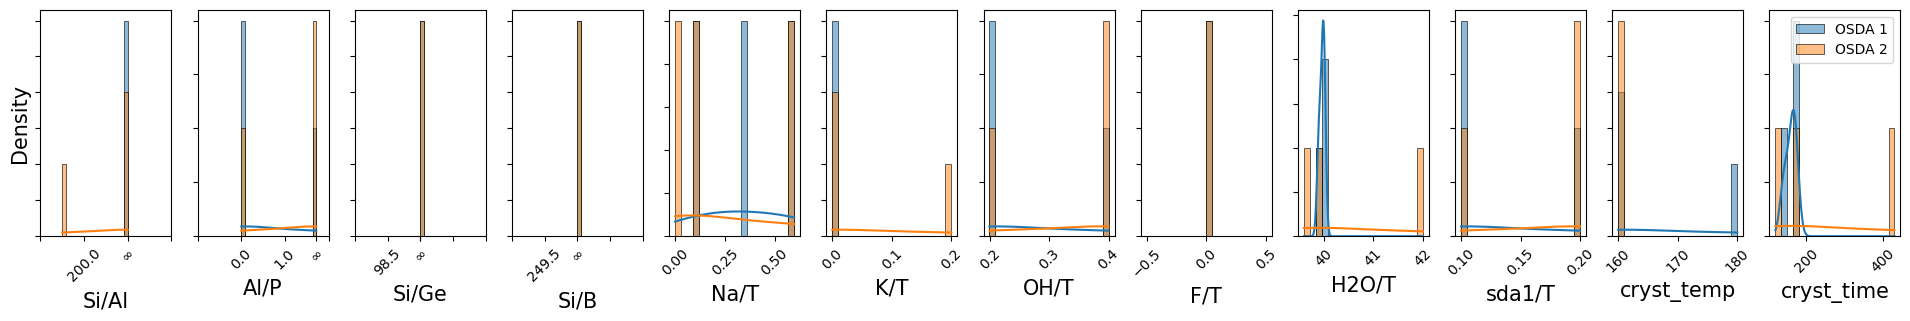

6
zeo: TON
osda 1: NCCCCCCCCN 14
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.86636555


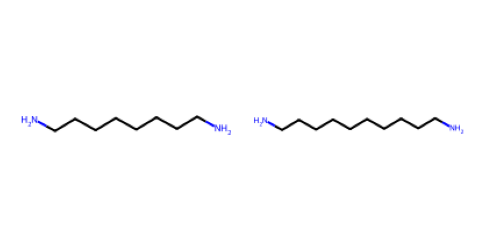

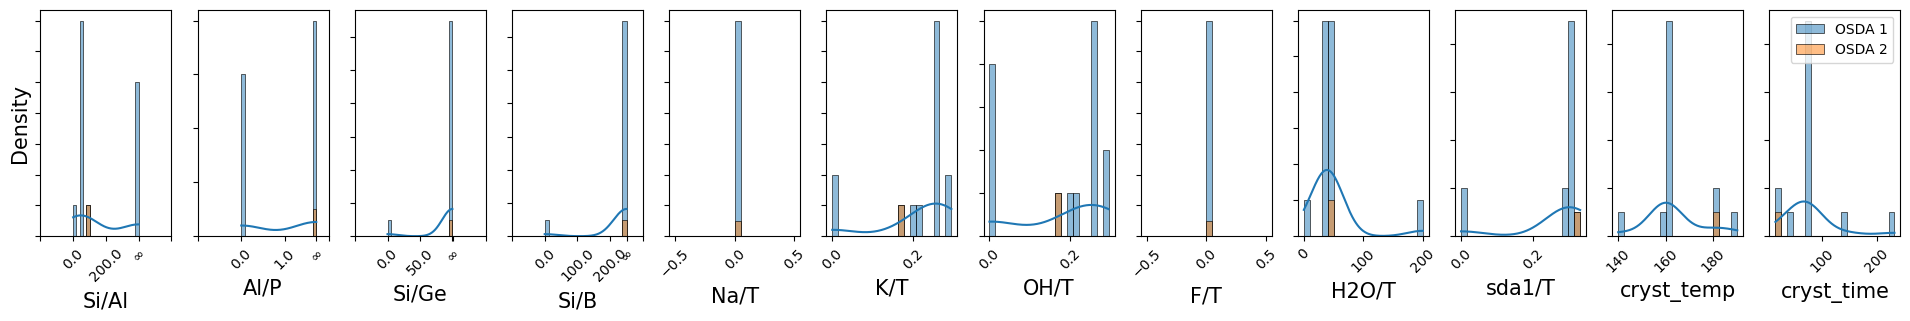

7
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9981285


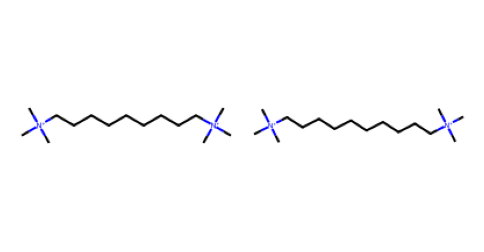

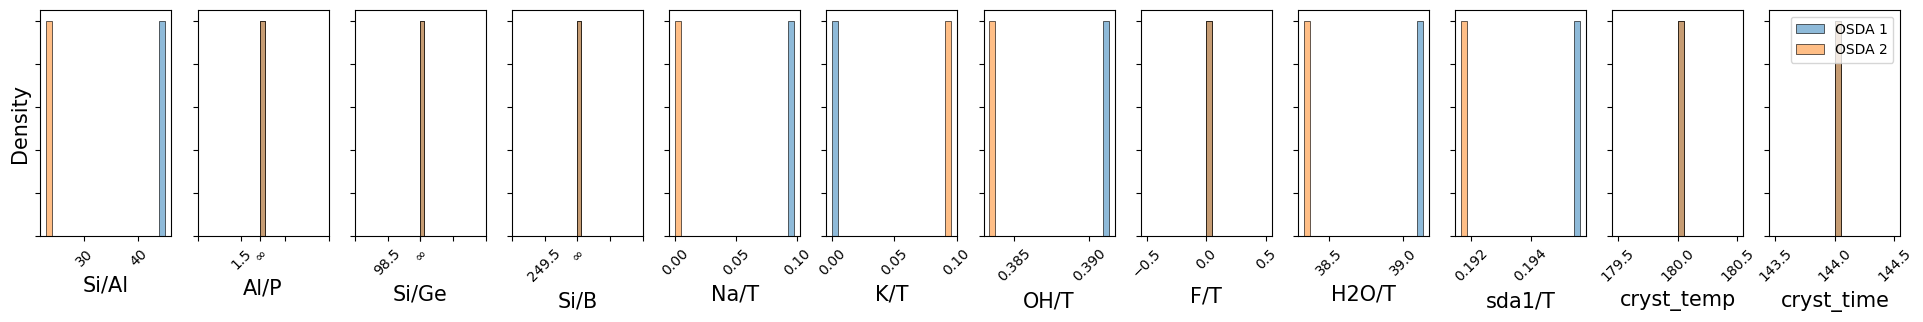

8
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9526736


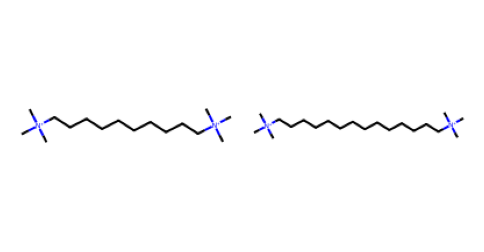

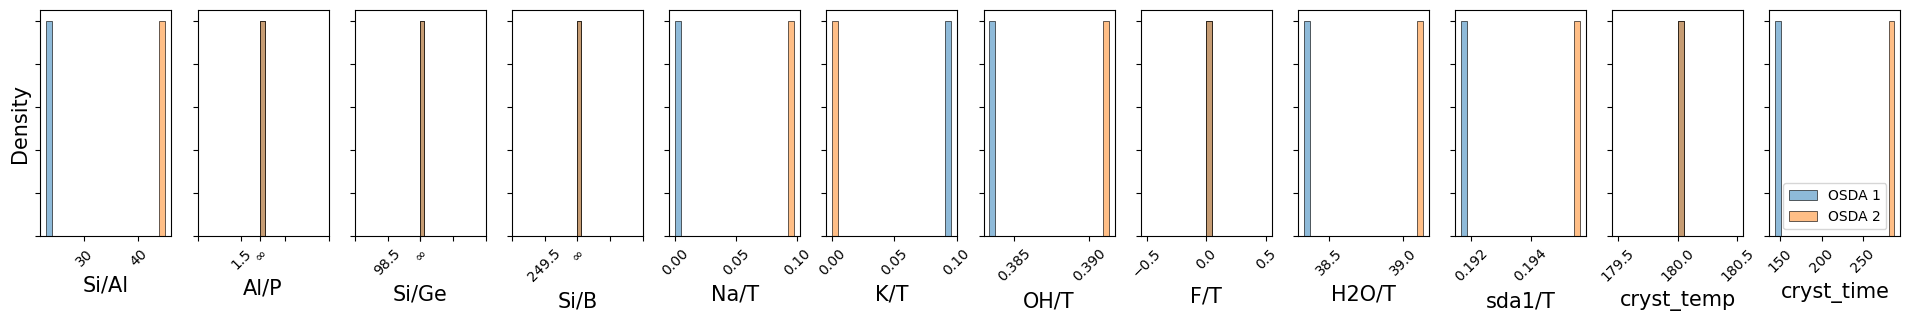

9
zeo: SFS
osda 1: CC[N+]1(CC)C(C)CCC2CCCCC21 1
osda 2: CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21 1
osda similarity: 1.0
synthesis similarity: 0.60988677


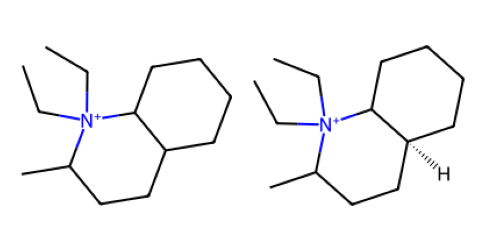

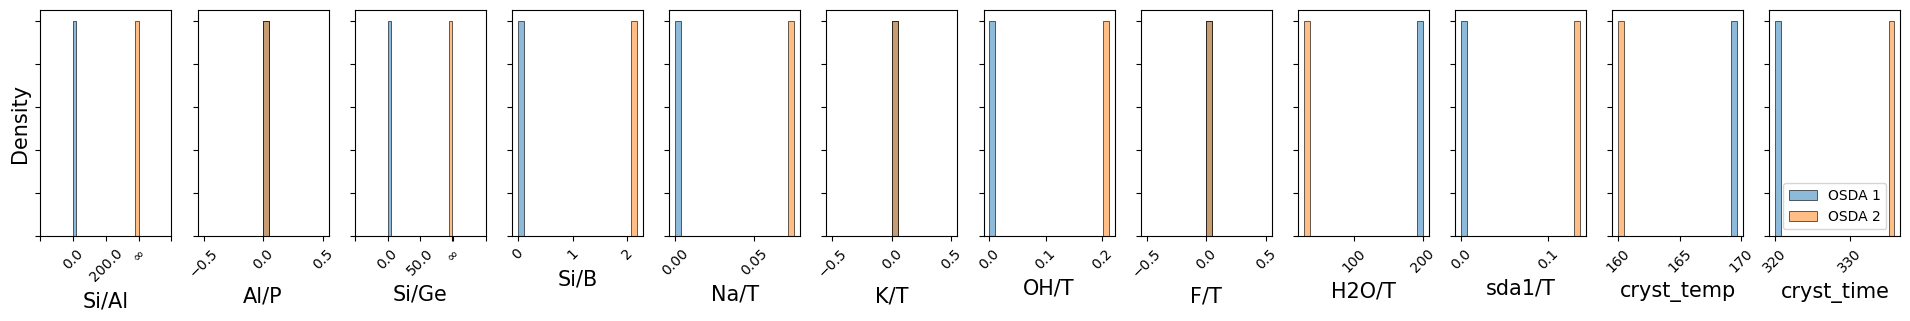

10
zeo: SSY
osda 1: CC[N+]1([C@H]2C[C@@H](C)CC(C)(C)C2)CCCC1 5
osda 2: CC[N+]1(C2CC(C)CC(C)(C)C2)CCCC1 1
osda similarity: 1.0
synthesis similarity: 0.95474684


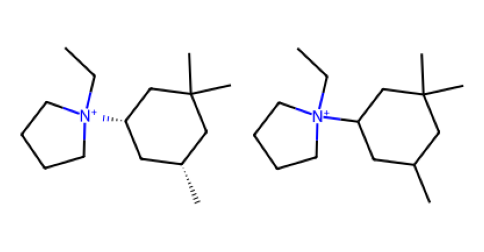

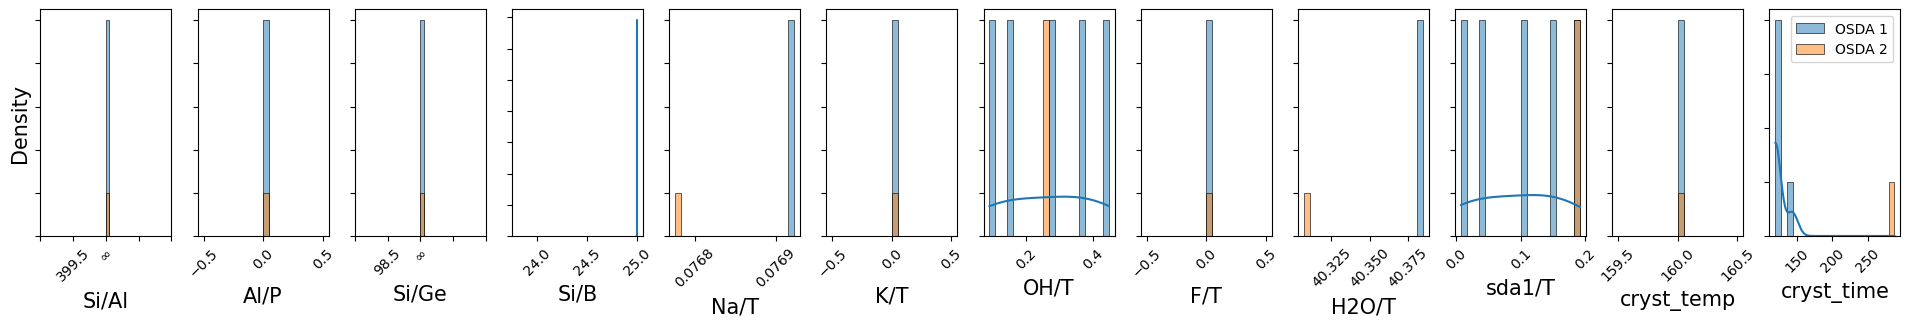

In [18]:
# Visualize some systems
for idx in range(len(df_osda_sim)):
    data = df_osda_sim.iloc[idx]
    zeo, osda_src, osda_ref, osda_sim, syn_sim = data['zeo'], data['osda_src'], data['osda_ref'], data['osda_sim'], data['syn_sim']

    df_zeo = df[df['zeo']==zeo]
    df_zeo = df_zeo.drop(columns=['zeo'])

    df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])
    df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

    print(idx)
    print('zeo:', zeo)
    print('osda 1:', osda_src, len(df_zeo_osda_src))
    print('osda 2:', osda_ref, len(df_zeo_osda_ref))
    print('osda similarity:', osda_sim)
    print('synthesis similarity:', syn_sim)
    
    visualize_smiles([osda_src, osda_ref])
    compare_gel_conds([df_zeo_osda_src, df_zeo_osda_ref], ['OSDA 1', 'OSDA 2'], kde=True)

    if idx == 10:
        break


# 2) Zeolite similarity

In [19]:
unique_zeo = list(df['zeo'].value_counts().keys())

zeo_sims, syn_sims = [], [] 
zeo_refs, zeo_srcs = [], []

for ref_idx in tqdm.tqdm(range(len(unique_zeo))):

    zeo_ref = unique_zeo[ref_idx] # Reference zeo

    if zeo_ref != 'Dense/Amorphous':
        df_zeo_ref = df[df['zeo']==zeo_ref].drop(columns=['zeo', 'osda'])

        for src_idx in range(ref_idx):  # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
            
            zeo_src = unique_zeo[src_idx] # Source zeo-OSDA

            if zeo_src != 'Dense/Amorphous':
                df_zeo_src = df[df['zeo']==zeo_src].drop(columns=['zeo', 'osda'])
                
                # 1) ZEOLITE SIMILARITY
                zeo_sim = get_zeolite_similarity(zeo_src, zeo_ref, feat_type='graph')

                # # 2) SYNTHESIS SIMILARITY
                # 2A) Cosine similarity
                syn_sim = cosine_similarity(df_zeo_src.values, df_zeo_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                # # 2B) Maximum Mean Discrepancy
                # syn_sim = maximum_mean_discrepancy(df_zeo_src.values, df_zeo_ref.values)

                zeo_sims.append(zeo_sim), syn_sims.append(syn_sim)
                zeo_refs.append(zeo_ref), zeo_srcs.append(zeo_src)

100%|██████████| 233/233 [01:48<00:00,  2.15it/s]


In [20]:
df_zeo_sim = pd.DataFrame({'zeo_ref': zeo_refs, 'zeo_src': zeo_srcs, 'zeo_sim': zeo_sims, 'syn_sim': syn_sims})
# df_zeo_sim.to_csv('df_zeo_sim.csv')

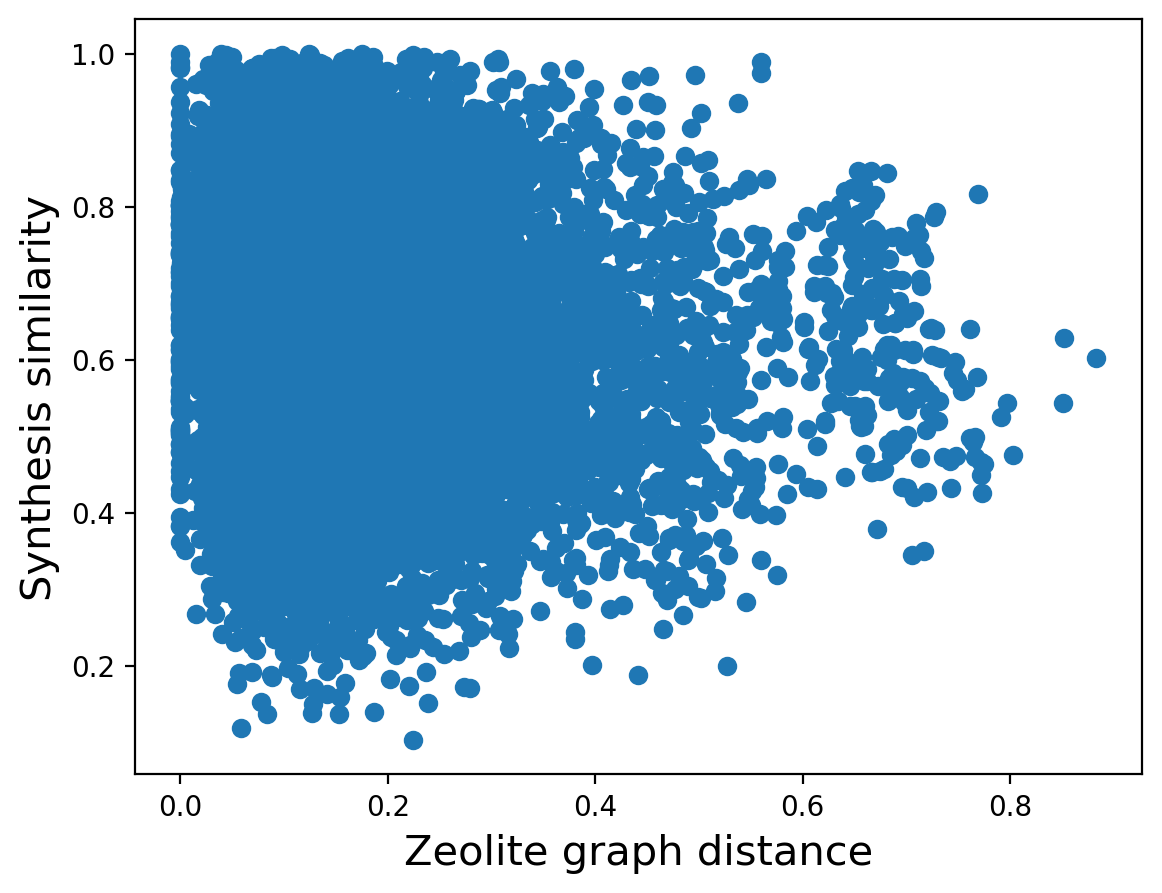

In [21]:
plt.figure(figsize=(6.5,5),dpi=200)
plt.scatter(df_zeo_sim['zeo_sim'], df_zeo_sim['syn_sim'])
# plt.hexbin(zeo_sims, syn_sims, cmap='inferno')
# ax = plt.gca()
# ax.set_facecolor('black')
plt.xlabel('Zeolite graph distance', fontsize=15)
plt.ylabel('Synthesis similarity', fontsize=15)
# cb = plt.colorbar()
# cb.set_label('Number of zeolite pairs', fontsize=15)
# plt.xlim(-0.00,1.015)
# plt.ylim(-0.02,1.015)
# plt.xlim(-0.00,1.02)
# plt.ylim(-0.01,2)
plt.show()

# 3) Zeolite-OSDA similarity (takes about 2h)

In [22]:
# unique_zeo_osda = list(df[['zeo', 'osda']].value_counts().keys())

# zeo_sims, osda_sims, syn_sims = [], [], []
# zeo_refs, osda_refs, zeo_srcs, osda_srcs = [], [], [], []

# for ref_idx in tqdm.tqdm(range(len(unique_zeo_osda))):

#     zeo_ref, osda_ref = unique_zeo_osda[ref_idx] # Reference zeo-OSDA

#     if (zeo_ref != 'Dense/Amorphous') and (osda_ref != 'OSDA-free'):
#         df_zeo_osda_ref = df[(df['zeo']==zeo_ref) & (df['osda']==osda_ref)].drop(columns=['zeo', 'osda'])

#         for src_idx in range(ref_idx):  # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
            
#             zeo_src, osda_src = unique_zeo_osda[src_idx] # Source zeo-OSDA

#             if (zeo_src != 'Dense/Amorphous') and (osda_src != 'OSDA-free'):
#                 df_zeo_osda_src = df[(df['zeo']==zeo_src) & (df['osda']==osda_src)].drop(columns=['zeo', 'osda'])

#                 # 1) ZEOLITE SIMILARITY
#                 zeo_sim = get_zeolite_similarity(zeo_src, zeo_ref, feat_type='be')

#                 # 2) OSDA SIMILARITY
#                 osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

#                 # 3) SYNTHESIS SIMILARITY
#                 syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
#                 syn_sim = syn_sim.mean() # scalar

#                 zeo_sims.append(zeo_sim), osda_sims.append(osda_sim), syn_sims.append(syn_sim)
#                 zeo_refs.append(zeo_ref), osda_refs.append(osda_ref), zeo_srcs.append(zeo_src), osda_srcs.append(osda_src)

In [23]:
# df_zeo_osda_sim = pd.DataFrame({'zeo_ref': zeo_refs, 'osda_ref': osda_refs, 'zeo_src': zeo_srcs, 'osda_src': osda_srcs, 'zeo_sim': zeo_sims, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
# df_zeo_osda_sim.to_csv('zeo_osda_sim-syn_cos_sim-zeo_be.csv')

In [24]:
# import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 1000
# plt.figure(figsize=(6.5,5),dpi=100)
# plt.hexbin(df_zeo_osda_sim['zeo_sim'], df_zeo_osda_sim['syn_sim'], gridsize=30, bins='log', cmap='inferno')
# ax = plt.gca()
# ax.set_facecolor('black')
# plt.xlabel('Zeolite binding similarity')
# plt.ylabel('Synthesis MMD dissimilarity')
# plt.show()

# GPT-4 augmentation

In [25]:
cols = dataset.ratio_names+dataset.cond_names

df_true = df[df['zeo'] == 'MTW'][cols] # Look at MTW

# Load GPT-4 generation
from gpt4_generated_dict import generated_dict

generated_dict_parsed = {}
for key, item in generated_dict.items():
    generated_dict_parsed[key] = {}
    for k, v in item.items():
        generated_dict_parsed[key][k] = float(v)
generated_dict_parsed_pooled = {}
for ratio in generated_dict_parsed[0].keys():
    ratio_list = [generated_dict_parsed[i][ratio] for i in range(len(generated_dict_parsed))]
    generated_dict_parsed_pooled[ratio] = ratio_list
df_gen = pd.DataFrame(generated_dict_parsed_pooled)
df_gen # GPT-4 generated MTW

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time
0,400.0,0.0,99.0,250.0,0.0,0.0,0.0,0.5,14.0,0.5,155.0,25.0
1,399.0,0.5,100.0,249.0,0.0,0.0,0.0,0.5,17.0,0.5,150.0,35.0
2,402.0,0.0,97.0,252.0,0.0,0.0,0.0,0.5,15.0,0.5,145.0,30.0
3,398.0,0.2,98.0,251.0,0.0,0.0,0.0,0.5,12.0,0.5,165.0,20.0
4,402.0,0.5,96.0,253.0,0.0,0.0,0.0,0.5,16.0,0.5,155.0,35.0
5,398.0,0.0,100.0,249.0,0.0,0.0,0.0,0.5,18.0,0.5,170.0,30.0
6,401.0,0.3,97.0,252.0,0.0,0.0,0.0,0.5,13.0,0.5,160.0,25.0
7,399.0,0.1,99.0,250.0,0.0,0.0,0.0,0.5,11.0,0.5,155.0,22.0
8,401.0,0.4,98.0,251.0,0.0,0.0,0.0,0.5,19.0,0.5,165.0,28.0
9,398.0,0.0,100.0,249.0,0.0,0.0,0.0,0.5,14.0,0.5,170.0,33.0


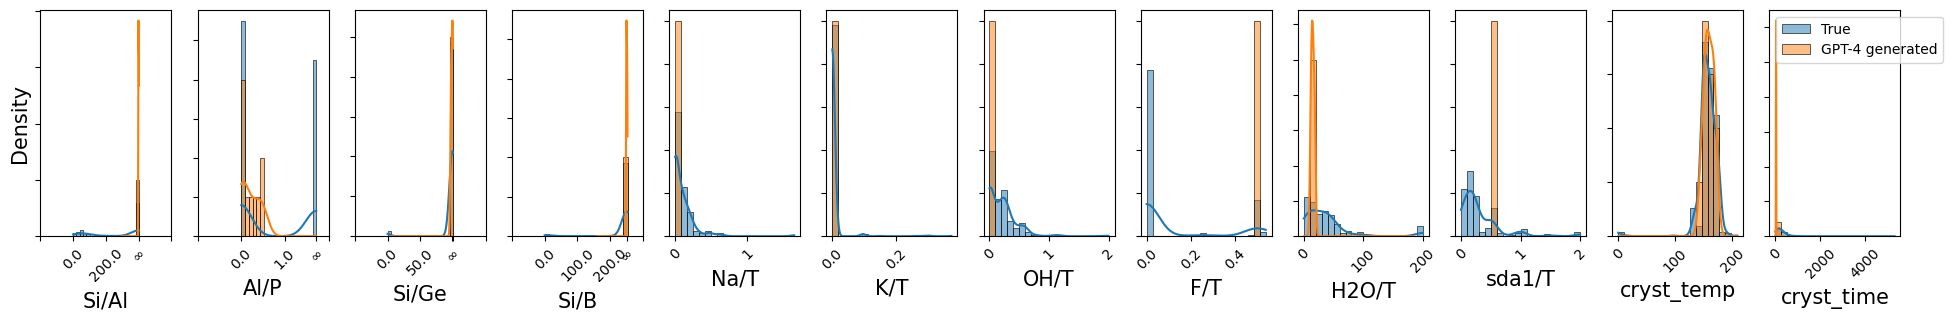

In [27]:
compare_gel_conds([df_true, df_gen], ['True', 'GPT-4 generated'], kde=True, common_norm=True)